# SOEN-6111 Project, Team#28

- Shreyans Sharma	
- Shubham Sharma	
- Shubhang Khattar - 40163063
- Bhavitha Yarlagadda

## Introduction

In this project we will create ML classification models using decision tree and K-nearest neighbors approach.
Models can ***predict the activity*** done by the subjects based on the motion sensor data

Data set used : MotionSense Dataset : Smartphone Sensor Data - HAR (https://www.kaggle.com/datasets/malekzadeh/motionsense-dataset)

### About Dataset

24 subjects (male and female) were asked to do 6 different activities in 15 trials in total. The motion sensor data was collected with an iPhone 6s in a 50Hz sample rate, which means 50 samples per second. The six activities done were the following, along with their abbreviation used in this dataset:

- dws: downstairs
- ups: upstairs
- sit: sitting
- std: standing
- wlk: walking
- jog: jogging

Of the 15 trials, the first 9 were "long" trials, while the trials 11-16 were the "short" version of their respective activity. Trial-ID 10 was left out. The trials in order were the following:

- 1: dws
- 2: dws
- 3: ups
- 4: ups
- 5: sit
- 6: std
- 7: wlk
- 8: wlk
- 9: jog
- 11: dws
- 12: ups
- 13: sit
- 14: std
- 15: wlk
- 16: jog

===========================================

Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from  sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, f1_score
from sklearn_evaluation import plot

import warnings
warnings.filterwarnings('ignore')

path = 'archive/A_DeviceMotion_data/A_DeviceMotion_data/'

## Data Loading and Processing

### Data Loading

In [2]:
# Extracting list of directories

list_of_folders = os.listdir(path)
list_of_directories = [path + i for i in list_of_folders]
list_of_dfs = []

activities = ['dws', 'ups', 'sit', 'std', 'wlk', 'jog']

# Iterating through the extracted directories and appending each csv to dataframes for each subject in each of the trials.

for i in list_of_directories:
    list_of_csv = os.listdir(i)
    for j in list_of_csv:
        k = pd.read_csv(i + '/' + j).rename(columns={'Unnamed: 0': 'time'})
        k['subject'] = int(j.split('_')[1].split('.')[0])
        k['activity'] = i.split('/')[-1].split('_')[0]
        k['trial'] = int(i.split('/')[-1].split('_')[1])
        
        # Deriving features from the given motion sensor data.
        
        k.insert(0, 'accel_x', k['userAcceleration.x'] + k['gravity.x'])
        k.insert(1, 'accel_y', k['userAcceleration.y'] + k['gravity.y'])
        k.insert(2, 'accel_z', k['userAcceleration.z'] + k['gravity.z'])
        k.insert(3, 'accel_norm', np.sqrt(k['accel_x']**2 + k['accel_y']**2 + k['accel_z']**2))
        list_of_dfs.append(k)
        
# Creating final dataset dataframe from the list of all individual dataframes.
df = pd.concat(list_of_dfs).set_index('time')

# Dropping unnecessary columns and renaming the ones for rotation.
df = df.drop(['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'gravity.x', 'gravity.y', 'gravity.z', 'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z'], axis=1)
df = df.rename(columns={'rotationRate.x': 'gyro_x', 'rotationRate.y': 'gyro_y', 'rotationRate.z': 'gyro_z'})

### Analyzing the dataset

In [3]:
df.sample(10)

,accel_x,accel_y,accel_z,accel_norm,gyro_x,gyro_y,gyro_z,subject,activity,trial
time,,,,,,,,,,
0,0.164567,0.182678,-0.971481,1.002112,0.015865,-0.012512,-0.001591,2,sit,13
4205,0.494949,0.820420,0.248276,0.989800,0.062001,0.129670,0.026752,14,std,6
8098,0.002213,1.004531,0.101883,1.009687,-0.054862,-0.100721,-0.018981,1,std,6
916,0.478333,2.423981,0.329315,2.492576,-0.505450,0.015026,-0.728203,19,dws,2
2094,0.020874,0.946563,-0.056915,0.948502,-0.584763,1.102421,-0.015409,18,ups,4
6333,0.341034,1.121750,0.340454,1.220875,-1.628291,0.865351,-2.054925,16,wlk,7
6843,0.029953,0.741776,0.000442,0.742381,1.171245,-1.243538,0.761688,7,wlk,7
3216,-0.159118,0.990280,-0.061051,1.004838,-0.001645,0.004972,0.004830,20,std,6
601,-0.033646,0.312637,0.159424,0.352548,0.248534,-1.679906,0.009071,2,wlk,8


In [4]:
df.shape

(1412865, 10)

In [5]:
df["activity"].value_counts()

wlk    344288
sit    338778
std    306427
ups    157285
jog    134231
dws    131856
Name: activity, dtype: int64

## Model Training and Evaluation

### Preparing Data Set

In [6]:
# Separating the dataset into a training set and a test set. 
# Making the cut between the long (1-9) as Training Dataset and the short trials (11-16) as Testing Dataset, 
# This ensures the evenly distribution of classes among training and testing data

train_df = df[(df.trial < 10)]
test_df = df[(df.trial > 10)]

# Extracting Features and Label for Training and Testing data.

X_train = train_df.iloc[:,:-3]
y_train = train_df.activity

X_test = test_df.iloc[:,:-3]
y_test = test_df.activity

## Decision Tree

***Model Creation and Training***

***Finding Maximum Optimal Depth***

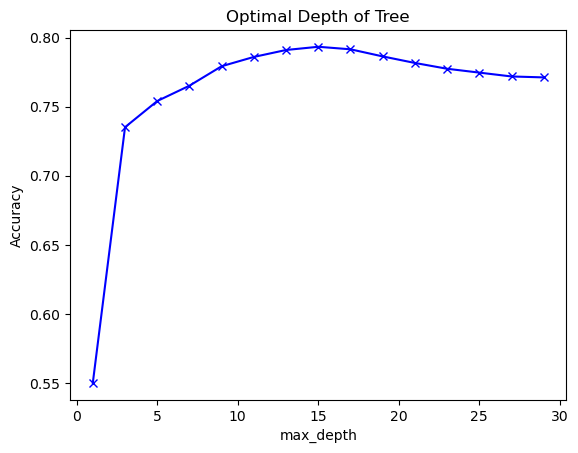

In [7]:
max_depth = range(1, 30, 2)

# List to store accuracy for each depth range
accuracy_dtc = []
for depth in max_depth:
    
    dtc = DecisionTreeClassifier(criterion="entropy",max_depth = depth, 
                             random_state = 0)
    dtc.fit(X_train, y_train)
    score = dtc.score(X_test, y_test)
    accuracy_dtc.append(score)

# Plotting max_depth vs Accuracy.
plt.plot(max_depth,accuracy_dtc,"bx-")
plt.xlabel("max_depth") 
plt.ylabel("Accuracy") 
plt.title("Optimal Depth of Tree")
plt.show()

In [8]:
accuracy_dtc

[0.5500559714440029,
 0.7350725214909224,
 0.754012292596381,
 0.7651160615414324,
 0.7792130203760195,
 0.7859386456419215,
 0.7909655149523714,
 0.7932858405824651,
 0.7914663914863058,
 0.7863127943781135,
 0.7815755886053606,
 0.7773754673087542,
 0.7745844384299029,
 0.771799444208087,
 0.7711205452916097]

***Opitmal Depth for the model is : 15***

In [9]:
# Create the Decesion Tree model classifier
dtc = DecisionTreeClassifier(criterion="entropy", max_depth = 15,random_state=0,)

In [10]:
# Training the model.
dtc.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=15, random_state=0)

### Decision Tree Evaluation

***Classification Report & Confusion Matrix***

In [11]:
# Prediciting labels for testing data
y_pred = dtc.predict(X_test)

              precision    recall  f1-score   support

         dws       0.36      0.37      0.36     22502
         jog       0.61      0.59      0.60     29904
         sit       1.00      0.99      1.00    104121
         std       0.99      0.94      0.96     81611
         ups       0.45      0.37      0.40     28009
         wlk       0.62      0.72      0.67     65272

    accuracy                           0.79    331419
   macro avg       0.67      0.66      0.66    331419
weighted avg       0.80      0.79      0.79    331419



<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

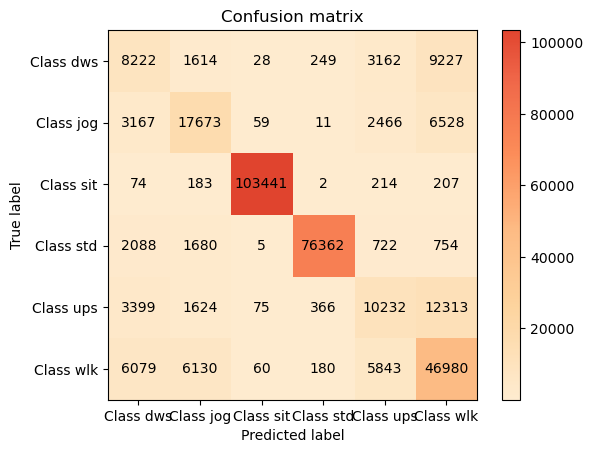

In [12]:
# Evaluating the performance of the model
print(classification_report(y_test, y_pred))
plot.confusion_matrix(y_test, y_pred)

## K-Nearest Neighbors

***Model Creation and Training***

***Find best K-Value (Elbow Method)***

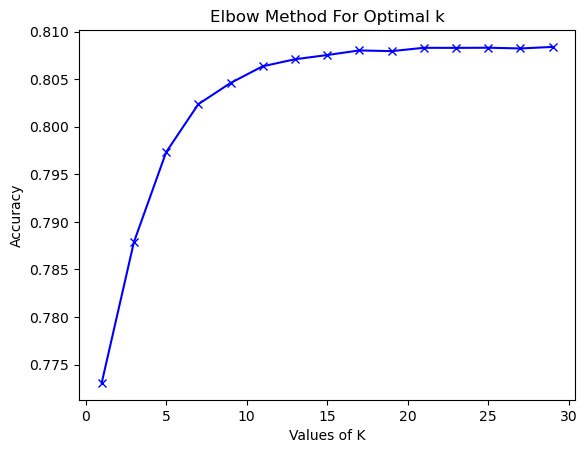

In [13]:
# List to store accuracy for each K range

accuracy_knn = []
K = range(1, 30, 2)
for num_clusters in K :
    knn = KNeighborsClassifier(n_neighbors=num_clusters)
    knn.fit(X_train,y_train)
    score = knn.score(X_test, y_test)
    accuracy_knn.append(score)

# Plotting K vs Accuracy.
plt.plot(K,accuracy_knn,"bx-")
plt.xlabel("Values of K") 
plt.ylabel("Accuracy") 
plt.title("Elbow Method For Optimal k")
plt.show()

In [14]:
accuracy_knn

[0.7730637048569937,
 0.7878667185647171,
 0.7973200088105993,
 0.8023710167491906,
 0.8045978051952363,
 0.806356907721042,
 0.8070931358793552,
 0.8075366831714537,
 0.8080224730627996,
 0.8079470398498577,
 0.8082970499579083,
 0.8082910153008729,
 0.8083061019434613,
 0.8082306687305194,
 0.8083905871419562]

***Opitmal K for KNN model is : 15***

In [15]:
# Create the K-Nearest Neighbor model classifier
knn = KNeighborsClassifier(n_neighbors=15)

In [16]:
# Training the model
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15)

### KNN Evaluation

***Classification Report & Confusion Matrix***

In [17]:
# Prediciting labels for testing data
y_pred = knn.predict(X_test)

              precision    recall  f1-score   support

         dws       0.40      0.44      0.42     22502
         jog       0.73      0.64      0.68     29904
         sit       1.00      0.95      0.97    104121
         std       0.99      0.94      0.96     81611
         ups       0.53      0.49      0.51     28009
         wlk       0.63      0.75      0.69     65272

    accuracy                           0.81    331419
   macro avg       0.71      0.70      0.71    331419
weighted avg       0.82      0.81      0.81    331419



<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

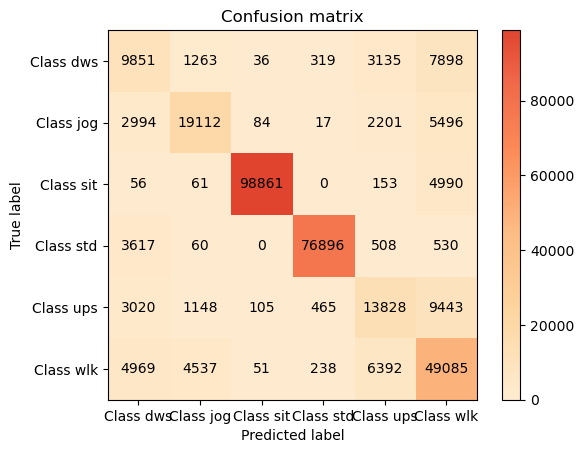

In [18]:
print(classification_report(y_test, y_pred))g
plot.confusion_matrix(y_test, y_pred)